# Add new analyses to the evaluation

Plot accuracy depending on chosen costs.

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle

import algorithms
import evaluation
import costs
from plotting.costs import plot_costs

In [3]:
np.random.seed(42)

# Load the evaluation data saved in experiment 20

In [4]:
with open('dataset/nursery/nursery_evaluation.pickle', 'rb') as f:
    data = pickle.load(f)
    
all_contexts, all_rewards = data

In [5]:
all_contexts

,form,children,housing,finance,health
2,1,1,1,1,1
4,1,1,1,1,3
6,1,1,1,1,2
7,1,1,1,1,3
8,1,1,1,1,1
...,...,...,...,...,...
12952,4,4,3,2,3
12953,4,4,3,2,1
12955,4,4,3,2,3
12956,4,4,3,2,1


## DROP for debug

In [6]:
# all_contexts = all_contexts.drop(columns=['form', 'children'])

In [7]:
all_rewards

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

## Set BETA parameter for the experiment

In [8]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [9]:
all_rewards.shape[0]

10000

In [10]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, all_contexts.shape[0]),
]

In [11]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [12]:
change_point_values

[1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 10000]

In [13]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.3396, 0.3366, 0.3238])

In [14]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        if i > 0:
            new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [15]:
new_contexts.shape, new_rewards.shape

((10000, 5), (10000, 3))

## Plot expected reward

Min expected reward for arm 1: 0.0
Min expected reward for arm 2: 0.022
Min expected reward for arm 3: 0.0


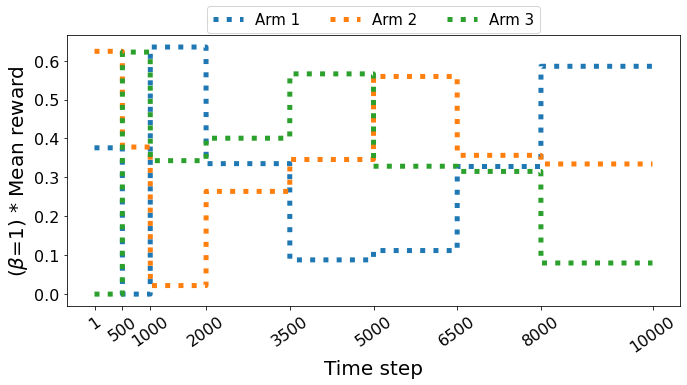

In [16]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


In [17]:
np.random.seed(42)

# Compute accuracy plot for Alg1

Chose several cost intervals. For each range of costs compute the accuracy plot (accuracy for l = number of observed features).

In [18]:
cost_intervals = [
    [0.01, 0.05],
#     [0.02, 0.06],
#     [0.03, 0.07],
#     [0.04, 0.08],
]

### Generate costs for each cost interval

In [19]:
cost_change_points = [3000, 5000, 7000, 9000]
interval_count = len(cost_change_points) + 1

all_costs_vectors = []
for cost_means_range in cost_intervals:


    # Mean of gaussian distribution random in interval [0, 0.02] 
    interval_means = [
        np.random.uniform(
            cost_means_range[0], cost_means_range[1], size=(new_contexts.shape[1],)
        ) for i in range(interval_count)
    ]

    # Fixed std
    interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count


    costs_obj = costs.NonstationaryGaussianCosts(
            feature_vector_size=new_contexts.shape[1],
            change_points=cost_change_points,
            interval_means=interval_means,
            interval_stds=interval_stds,
            random_seed=42,
        )

    costs_vector = []
    for t in range(new_contexts.shape[0]):
        costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
        costs_vector.append(costs_at_t)

    costs_vector = np.stack(costs_vector)
    all_costs_vectors.append(costs_vector)

## Run evaluation for different costs_vectors

In [20]:
def get_accuracy(alg1_object):
    N_FEATURES = alg1_object.max_no_red_context
    l_counts = np.zeros(N_FEATURES+1)
    l_rewards = np.zeros(N_FEATURES+1)
    
    for observation, reward in zip(alg1_object.selected_context_SimOOS, alg1_object.collected_rewards_SimOOS):
        num_observed = np.count_nonzero(observation)
        for k in range(num_observed+1):
            l_counts[k] += 1
            l_rewards[k] += reward  
            
    return l_rewards / l_counts

In [21]:
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 1

In [22]:
accuracies_alg1 = {}

for i, cost_interval in enumerate(cost_intervals):
    interval_costs_vector = all_costs_vectors[i]
    COSTS_RANGE_SIZE = cost_interval[1] - cost_interval[0]
    
    # Run evaluation (possibly with repetition)
    accuracies_to_average = np.zeros((NUM_REPETITIONS, new_contexts.shape[1]+1))
    for rep in range(NUM_REPETITIONS):
        p_alg1 = algorithms.Algorithm1(
            all_contexts=new_contexts, 
            number_of_actions=new_rewards.shape[1],
            max_no_red_context=new_contexts.shape[1],
            beta=BETA,
            delta=0.04,
            window_length=250,
            costs_range=COSTS_RANGE_SIZE,

        )

        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            s = time.time()
            gain_alg1 = evaluation.evaluate_on_synthetic_data(
                p_alg1,
                new_contexts[:NUM_OF_TRIALS],
                new_rewards[:NUM_OF_TRIALS],
                costs_vector[:NUM_OF_TRIALS],
                beta=BETA,
                stop_after=NUM_OF_TRIALS,
            )
            print(f"Took {time.time() - s} seconds")
        
        accuracy = get_accuracy(p_alg1)  
        accuracies_to_average[rep, :] = accuracy

    mean_accuracy = np.mean(accuracies_to_average, axis=0)
    print(f"Average accuracy: {mean_accuracy}")
       
    accuracies_alg1[tuple(cost_interval)] = mean_accuracy

Round 0, time 2022-05-30 17:15:28.013345
Round 500, time 2022-05-30 17:16:39.221434
Round 1000, time 2022-05-30 17:17:47.748598
Round 1500, time 2022-05-30 17:18:59.330094
Round 2000, time 2022-05-30 17:20:09.932924
Round 2500, time 2022-05-30 17:21:17.062979
Round 3000, time 2022-05-30 17:22:24.144940
Round 3500, time 2022-05-30 17:23:30.979853
Round 4000, time 2022-05-30 17:24:41.889992
Round 4500, time 2022-05-30 17:25:48.738062
Round 5000, time 2022-05-30 17:26:55.701123
Round 5500, time 2022-05-30 17:28:02.738776
Round 6000, time 2022-05-30 17:29:09.614086
Round 6500, time 2022-05-30 17:30:16.344073
Round 7000, time 2022-05-30 17:31:23.504109
Round 7500, time 2022-05-30 17:32:30.253015
Round 8000, time 2022-05-30 17:33:37.133593
Round 8500, time 2022-05-30 17:34:43.744763
Round 9000, time 2022-05-30 17:35:51.110506
Round 9500, time 2022-05-30 17:36:58.047402
Algorithm1 (beta=1, delta=0.04, w=250)
Beta = 1
Total gain: 5834.659653308171
	Total reward: 6919.0
	Total cost: 1084.340346

In [23]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))
all_stationarity_regions = [(l, r) for l,r in zip(all_change_point_values, all_change_point_values[1:])]
N_STATIONARY_PERIODS = len(all_stationarity_regions)

cost_means = np.zeros((N_STATIONARY_PERIODS, costs_vector.shape[1]))
for reg_num, region in enumerate(all_stationarity_regions):
    region_costs = costs_vector[slice(*region)]
    cost_means[reg_num, :] = region_costs.mean(axis=0)


accuracies_oracle = {}

for i, cost_interval in enumerate(cost_intervals):
    interval_costs_vector = all_costs_vectors[i]
    COSTS_RANGE_SIZE = cost_interval[1] - cost_interval[0]
    
    # Run evaluation (possibly with repetition)
    accuracies_to_average = np.zeros((NUM_REPETITIONS, new_contexts.shape[1]+1))
    for rep in range(NUM_REPETITIONS):
        p_alg1 = algorithms.Algorithm1_Oracle(
            all_contexts=new_contexts,
            all_rewards=new_rewards,
            cost_means=cost_means,
            stationarity_periods=all_stationarity_regions,
            number_of_actions=new_rewards.shape[1],
            max_no_red_context=new_contexts.shape[1],
            beta_SimOOS=BETA,
        )

        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            s = time.time()
            gain_alg1 = evaluation.evaluate_on_synthetic_data(
                p_alg1,
                new_contexts[:NUM_OF_TRIALS],
                new_rewards[:NUM_OF_TRIALS],
                costs_vector[:NUM_OF_TRIALS],
                beta=BETA,
                stop_after=NUM_OF_TRIALS,
            )
            print(f"Took {time.time() - s} seconds")
        
        accuracy = get_accuracy(p_alg1)  
        accuracies_to_average[rep, :] = accuracy

    mean_accuracy = np.mean(accuracies_to_average, axis=0)
    print(f"Average accuracy: {mean_accuracy}")
       
    accuracies_oracle[tuple(cost_interval)] = mean_accuracy

/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits/algorithms/oracle_alg1.py:78: RuntimeWarning: invalid value encountered in double_scalars
  true_average_reward[per_num, i, j, k] = sum_of_rewards[per_num, i, j, k] / number_of_visits_for_average_reward[per_num, i, j, k]


Trial 0, time 2022-05-30 17:38:05.670346
Trial 500, time 2022-05-30 17:38:05.675923
Trial 1000, time 2022-05-30 17:38:05.681621
Trial 1500, time 2022-05-30 17:38:05.687605
Trial 2000, time 2022-05-30 17:38:05.693504
Trial 2500, time 2022-05-30 17:38:05.699763
Trial 3000, time 2022-05-30 17:38:05.706005
Trial 3500, time 2022-05-30 17:38:05.711666
Trial 4000, time 2022-05-30 17:38:05.718151
Trial 4500, time 2022-05-30 17:38:05.724649
Trial 5000, time 2022-05-30 17:38:05.731105
Trial 5500, time 2022-05-30 17:38:05.736715
Trial 6000, time 2022-05-30 17:38:05.742419
Trial 6500, time 2022-05-30 17:38:05.747962
Trial 7000, time 2022-05-30 17:38:05.753796
Trial 7500, time 2022-05-30 17:38:05.760593
Trial 8000, time 2022-05-30 17:38:05.767121
Trial 8500, time 2022-05-30 17:38:05.773800
Trial 9000, time 2022-05-30 17:38:05.780422
Trial 9500, time 2022-05-30 17:38:05.787127
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 7567.296897971211
	Total reward: 8583.0
	Total cost: 1015.7031020287809
Exec

In [24]:
accuracies = {
    'Algorithm1': accuracies_alg1,
    'Oracle': accuracies_oracle,
}

## Save accuracies

In [25]:
with open('experiments/nursery/results/accuracies.pickle', 'wb') as f:
    pickle.dump(accuracies, f)

## Load accuracies

In [26]:
with open('experiments/nursery/results/accuracies.pickle', 'rb') as f:
    accuracies = pickle.load(f)

In [27]:
accuracies = {
    'Algorithm1': next(iter(accuracies_alg1.values())),
    'Oracle': next(iter(accuracies_oracle)),
}

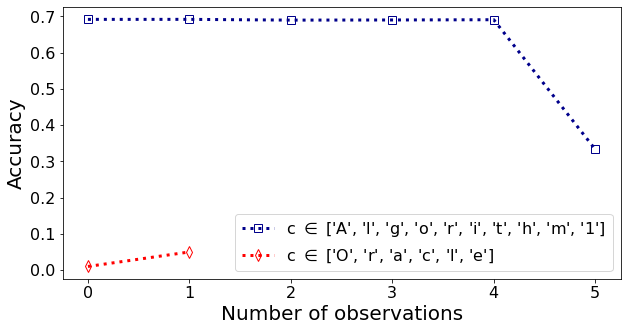

In [28]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1, figsize=(10, 5))
ind_to_params = {
        # ind: (mark, color)
        0: ('s', 'darkblue'), 1: ('d','red'), 2: ('o','deepskyblue'), 3: ('>','orange'),
        4: ('^', 'm'), 5: ('<', 'k'), 6: ('x','green'),
    }

for ind, (cost_interval, accuracy_for_cost) in enumerate(accuracies.items()):
    mark, color = ind_to_params[ind]
    ax.plot(
        range(len(accuracy_for_cost)),
        accuracy_for_cost,
        label=fr"c $\in$ {list(cost_interval)}",
        marker=mark, markersize=8, fillstyle='none',
        c=color, linestyle=':', linewidth=3,
    )
    
ax.set_xlabel('Number of observations', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # Only integer labels

plt.legend(prop={'size': 16});
plt.show()

- Plot without up to l
- plot oracle
- plot simoos
- think about it
